### Initialisation

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score

In [2]:
! /usr/local/bin/sshfs -o IdentityFile=~/.ssh/bioinf_id_rsa -o volname=Home davelangers@bioinf.nl:/homes/davelangers /Volumes/Data/Bioinf/Home -p 4235

mount_osxfuse: mount point /Volumes/Data/Bioinf/Home is itself on a OSXFUSE volume


### Read data

In [3]:
docnames = pd.read_csv('docidmapping.txt',
                       sep='\t',
                       names=['doc', 'name'],
                       converters={'doc': lambda x: int(x[4:]),
                                   'name': lambda x: str(x)[:-4]
                                  },
                       index_col='doc'
                      )
docnames

,name
doc,
1,Archief_van_dhr._vd_Meijs_inzake_project_Payro...
2,Archief_van_dhr._vd_Meijs_inzake_project_Payro...
3,BSD-Handelingsnummer_143-118
4,BSD-Handelingsnummer_15-XV
5,FEZ_12893
...,...
265,Stukken_met_betrekking_Bureau_Dienstreizen_199...
266,VA-bestand_project_Beheer_Rijksbegroting_perio...
267,VA-bestand_project_Beheer_Rijksbegroting_perio...


In [4]:
embedding = pd.read_csv('docvectors.txt',
                        sep='\t'
                       )
embedding

,doc_1,doc_2,doc_3,doc_4,doc_5,doc_6,doc_7,doc_8,doc_9,doc_10,...,doc_260,doc_261,doc_262,doc_263,doc_264,doc_265,doc_266,doc_267,doc_268,doc_269
0,-15020.629648,-24212.030613,-1917.042495,-40746.863356,-2438.890698,-586.062392,-1983.679373,-839.475474,-675.037106,-158.581574,...,-2500.315425,-10935.989574,-24247.430669,-16664.945246,-26211.271615,-13261.389176,-21096.092972,-25791.358818,-18404.007042,-1216.759655
1,10390.756846,17076.301241,1509.544126,30831.166582,1620.431770,639.205612,1755.225617,668.166607,512.462537,112.225479,...,1884.321751,7305.332363,20142.680062,11800.517777,23525.753264,9431.118975,16690.331568,17040.647184,15570.581457,1188.680931
2,-5113.254468,-6690.626770,-519.462749,-11572.381749,111.275017,208.518679,-638.431074,-66.948308,179.360299,4.799193,...,-369.170797,239.297186,-6385.091634,2310.151474,-6901.329047,-2888.972947,-6199.783965,-2160.564268,-5277.086346,-304.666462
3,-217.905544,-4232.709939,-278.440061,-5378.023425,-372.405242,-354.512889,-533.543332,-248.075589,-129.737158,-51.521301,...,-491.745160,-3207.089809,-5240.384677,-5607.523650,-6215.585471,-3961.323406,-5630.862723,-4546.811622,-3717.512673,-283.563893
4,1906.176713,3797.089749,62.209565,3927.605836,1272.621540,348.517697,-7.153466,238.843075,356.968891,70.737620,...,770.906128,4851.964285,2121.685180,7286.729988,3224.950688,2096.608335,1865.633321,6275.159077,-202.380798,68.709435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,6290.956717,11661.203937,615.713091,15728.561290,1173.078412,258.867348,781.829816,361.201662,345.854123,72.733877,...,1348.718602,6286.285116,9744.170710,9687.281027,11029.798502,4344.838279,8736.209914,10128.095229,6506.037368,485.431053
96,-27608.832758,-45452.042309,-3600.699160,-78160.033361,-4175.897507,-1308.623727,-4186.390251,-1594.131654,-1298.892609,-300.953352,...,-4478.030038,-24037.257083,-47740.277526,-35266.357650,-53835.352295,-23653.327384,-41054.604737,-48049.662746,-36199.949285,-2344.010127
97,10636.721269,16444.139982,1000.709292,24713.319586,915.729965,206.023859,1296.437094,378.932282,381.737115,85.839004,...,974.263894,6553.989497,14214.948355,8445.546914,13806.805934,6688.581125,10757.386152,10100.527404,11091.357743,751.223742
98,-8777.695914,-10851.227286,-854.426169,-19045.631926,-702.780381,-306.394495,-1052.884039,-272.504917,-304.058585,-54.047506,...,-902.244606,-5512.783578,-12424.448482,-8802.473511,-12449.010576,-5711.324836,-8185.712006,-7705.629435,-8610.261332,-643.758655


In [5]:
X = embedding.to_numpy().T
Y = docnames['name'].str.startswith('I').values.astype(np.int)  # "Inv.nr.*" documenten moeten wél bewaard

### Resubstitution with training data

In [6]:
def predict(X_train, Y_train, X_test=None):
    if X_test is None:
        X_test = X_train
    model = GaussianNB()
    model.fit(X_train, Y_train)
    return model.predict_proba(X_test)[:, 1]

Y_pred = predict(X, Y)

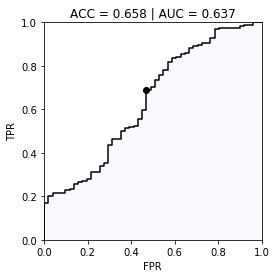

,0,1
0,27,24
1,68,150


In [7]:
fpr, tpr, thr = roc_curve(Y, Y_pred)
threshold = np.argmax((1.0-fpr) * tpr)

plt.fill_between(fpr, tpr, color='ghostwhite')
plt.plot(fpr, tpr, '-k')
plt.plot(fpr[threshold], tpr[threshold], 'ok')
plt.axis('square'); plt.axis([0, 1, 0, 1])
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title(f'ACC = {accuracy_score(Y, Y_pred >= thr[threshold]):1.3f} | AUC = {auc(fpr, tpr):1.3f}')
plt.show()

pd.DataFrame(confusion_matrix(Y, Y_pred >= thr[threshold]))

### Cross-validation with Leave-One-Out

In [8]:
def predict_LOO(X, Y):
    result = np.empty_like(Y, dtype=np.float)
    for train_index, test_index in LeaveOneOut().split(X):
        result[test_index] = predict(X[train_index, :], Y[train_index], X[test_index, :])
        print(end='.')
    return result

Y_pred = predict_LOO(X, Y)

.............................................................................................................................................................................................................................................................................

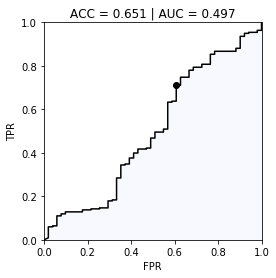

,0,1
0,20,31
1,63,155


In [9]:
fpr, tpr, thr = roc_curve(Y, Y_pred)
threshold = np.argmax((1.0-fpr) * tpr)

plt.fill_between(fpr, tpr, color='ghostwhite')
plt.plot(fpr, tpr, '-k')
plt.plot(fpr[threshold], tpr[threshold], 'ok')
plt.axis('square'); plt.axis([0, 1, 0, 1])
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title(f'ACC = {accuracy_score(Y, Y_pred >= thr[threshold]):1.3f} | AUC = {auc(fpr, tpr):1.3f}')
plt.show()

pd.DataFrame(confusion_matrix(Y, Y_pred >= thr[threshold]))

***

©2021 - [Dave R.M. Langers](d.r.m.langers@pl.hanze.nl)